In [1]:
import sys
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K

from sklearn.metrics import confusion_matrix
import itertools

from tqdm import tqdm

# reserve only the 30% of the GPU memory
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
width = 50
height = 10
channels = 3
classes = 6
dataset_dir = '/lustrehome/adipilato/ParticleID/new_datasets/5PartPerEvent/padded/test/'
save_dir = '/lustrehome/adipilato/ParticleID/PID-ER_v2/models/'
plot_dir = '/lustrehome/adipilato/ParticleID/PID-ER_v2/plots/'
padding = 'padding' + str(height)
model_name= padding + '_ATmodelV2'
history_name = model_name + '_history'

class_labels = {22:0, -11:1, 11:1, -13:2, 13:2, -211:3, 211:3, 311:4, -1:5, -9999:5}
class_names = np.array(['γ', 'e$^{±}$', 'μ$^{±}$', 'π$^{±}$', 'K$^{0}$', 'inc'])

In [3]:
# arrays of data needed for training

data_list = []
pid_list = []
en_list = []

# read dataset
files = [f for f in os.listdir(dataset_dir) if f.endswith("h5")]

for name in tqdm(files):
    print("Reading file", name)
    data = pd.read_hdf(dataset_dir + name)
    num_tracks = data.trackster.max()
    print(num_tracks)
    
    tracksters = np.array([data.E.values, data.eta.values, data.phi.values]).T.reshape(-1, width, height, channels)

    pid_vals = np.array([data.pid.values]).T.reshape(-1, width*height)
    select = (np.max(pid_vals,axis=1)==0)
    pid_vals=np.max(np.abs(pid_vals),axis=1)
    pid_vals[select]=pid_vals[select]*-1.0
    pid_vals = pid_vals.tolist()
    pid_arr = [class_labels[x] for x in pid_vals]
    en_vals = np.array([data.genE.values]).T.reshape(-1, width*height)
    en_arr = np.max(en_vals,axis=1)

    data_list.append(tracksters)
    pid_list.append(pid_arr)
    en_list.append(en_arr)

  0%|          | 0/3 [00:00<?, ?it/s]

Reading file step4_14_padded.h5
297376


 33%|███▎      | 1/3 [00:58<01:56, 58.41s/it]

Reading file step4_16_padded.h5
29662


 67%|██████▋   | 2/3 [01:12<00:44, 44.99s/it]

Reading file step4_15_padded.h5
297397


100%|██████████| 3/3 [02:09<00:00, 48.63s/it]


In [4]:
data_array = np.array([item for sublist in data_list for item in sublist])
print(data_array.shape)

(624435, 50, 10, 3)


In [5]:
pid_array = np.array([item for sublist in pid_list for item in sublist])
pid_array_cat = keras.utils.to_categorical(pid_array, num_classes=classes, dtype='float32')
print(pid_array.shape)

(624435,)


In [6]:
en_array = np.array([item for sublist in en_list for item in sublist])
print(en_array.shape)

(624435,)


In [7]:
####### NORMALIZE THE ENERGY ########

mean_en = 123.61015624208174
std_en = 149.02813697719492
# mean_en = np.mean(en_array)
# std_en = np.std(en_array)

print('Mean Energy Value: {}'.format(mean_en))
print('Std Energy Value: {}'.format(std_en))

en_array_norm = (en_array - mean_en)/std_en

Mean Energy Value: 123.61015624208174
Std Energy Value: 149.02813697719492


In [8]:
# Load the trained model
model = load_model(save_dir + model_name + '.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 10, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 10, 16)   256         input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 50, 10, 16)   2320        conv1[0][0]                      
________________________________________________________________________

In [9]:
# Score trained model

scores = model.evaluate(data_array, {'pid_output': pid_array_cat, 'enreg_output': en_array_norm}, verbose=1)
print("Scores: {}".format(scores))

624435/624435 [==============================] - 85s 136us/step
Scores: [0.9459694449551285, 0.436644787580617, 0.42199567861685183, 0.7851177464420206, 0.42199567861685183]


In [10]:
# Perform inference

results = model.predict(data_array)

print('****** PID START*******')
print('True Particle IDs= {} '.format(pid_array))
pid_results = results[0]
pid_predicted = np.argmax(pid_results, axis=1)
print('Predicted Particle ID Probabilities= {} '.format(pid_results))
print('Predicted Particle IDs= {} '.format(pid_predicted))
print('****** PID END*******')

print('****** ENREG START*******')
print('True Particle Energies= {} '.format(en_array))
enreg_results = results[1]
enreg_results = (enreg_results * std_en) + mean_en
enreg_results = np.squeeze(enreg_results)
print('Predicted Particle Energies= {}'.format(enreg_results))
print('****** ENREG END*******')

****** PID START*******
True Particle IDs= [0 0 5 ... 5 5 3] 
Predicted Particle ID Probabilities= [[3.4018406e-01 6.5761501e-01 2.1180176e-05 7.6991681e-04 4.6414370e-04
  9.4574218e-04]
 [3.4943700e-01 6.4945674e-01 2.9640844e-06 8.8630070e-04 2.0591971e-04
  1.1107217e-05]
 [3.8813336e-03 3.5208745e-03 3.5235128e-06 5.0686358e-04 6.7518768e-04
  9.9141216e-01]
 ...
 [6.3144960e-03 5.0021186e-03 2.2081085e-05 1.0050575e-03 1.2409039e-03
  9.8641533e-01]
 [5.2368408e-03 4.1348548e-03 6.7028901e-05 1.7910139e-03 2.2293814e-03
  9.8654085e-01]
 [6.0025119e-04 2.5297390e-04 7.4150616e-05 4.3526906e-01 5.6276697e-01
  1.0365562e-03]] 
Predicted Particle IDs= [1 1 5 ... 5 5 4] 
****** PID END*******
****** ENREG START*******
True Particle Energies= [222.81207275 399.65353394   0.         ...   0.           0.
 338.36923218] 
Predicted Particle Energies= [178.64172 317.38458 123.61015 ... 123.61015 123.61015 281.627  ]
****** ENREG END*******


In [11]:
gamma_true_en = en_array[pid_array==0]
electron_true_en = en_array[pid_array==1]
muon_true_en = en_array[pid_array==2]
pion_c_true_en = en_array[pid_array==3]
kaon_n_true_en = en_array[pid_array==4]

gamma_reco_en = enreg_results[pid_array==0]
electron_reco_en = enreg_results[pid_array==1]
muon_reco_en = enreg_results[pid_array==2]
pion_c_reco_en = enreg_results[pid_array==3]
kaon_n_reco_en = enreg_results[pid_array==4]

In [12]:
maxval = np.amax(gamma_true_en)
minval = np.amin(gamma_true_en)
print(maxval)
print(minval)

449.9986267089844
5.0078043937683105


In [13]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=13, y=1.04)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.ylabel('True class', labelpad=10, fontsize=13)
    plt.xlabel('Predicted class', labelpad=10, fontsize=13)
    plt.tight_layout()

Confusion matrix
[[6.30e-01 3.51e-01 6.10e-04 4.44e-03 1.09e-03 1.28e-02]
 [3.62e-01 6.20e-01 9.42e-05 3.20e-03 4.00e-04 1.44e-02]
 [7.71e-02 1.92e-02 4.33e-01 1.27e-01 9.59e-03 3.34e-01]
 [5.67e-03 6.33e-03 2.40e-03 5.27e-01 4.02e-01 5.71e-02]
 [4.47e-03 2.21e-03 1.78e-03 2.74e-01 6.56e-01 6.17e-02]
 [2.02e-03 1.79e-03 1.24e-03 7.16e-03 7.97e-03 9.80e-01]]


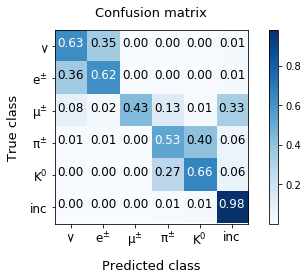

In [14]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(pid_array, pid_predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(0)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')
plt.savefig(plot_dir + model_name + '_confusion_matrix.pdf', format='pdf')
plt.show()

In [15]:
file = pd.read_hdf(save_dir + history_name + ".h5", "history") #.values
print(file.head())

file = file.values

val_loss = file[:, 0]
val_pid_loss = file[:, 1]
val_en_loss = file[:,2]

val_pid_acc =file[:,3]

train_loss = file[:, 5]
train_pid_loss = file[:,6]
train_en_loss = file[:,7]

train_pid_acc = file[:, 8]

n_epochs = len(file)
n_epochs = np.arange(1, n_epochs+1)
print("Number of Epochs: ", n_epochs)

   val_loss  val_pid_output_loss  val_enreg_output_loss  val_pid_output_acc  \
0  0.951802             0.437316               0.427022            0.785395   
1  0.946790             0.436258               0.423281            0.785538   
2  0.960708             0.437972               0.435142            0.784690   
3  0.949322             0.438319               0.423339            0.783996   
4  0.952512             0.439707               0.424864            0.783888   

   val_enreg_output_mean_squared_error      loss  pid_output_loss  \
0                             0.427022  0.893649         0.429374   
1                             0.423281  0.889665         0.426242   
2                             0.435142  0.885832         0.423080   
3                             0.423339  0.881270         0.419354   
4                             0.424864  0.876586         0.415550   

   enreg_output_loss  pid_output_acc  enreg_output_mean_squared_error  
0           0.378399        0.790243  

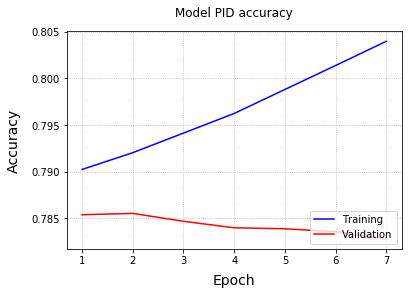

In [16]:
fig5 = plt.figure(5)
plt.plot(n_epochs, train_pid_acc, '-b', label='Training')
plt.plot(n_epochs, val_pid_acc, '-r', label='Validation')

plt.title('Model PID accuracy', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
plt.savefig(plot_dir + model_name + '_pid_accuracy.pdf', format='pdf')
fig5.show()

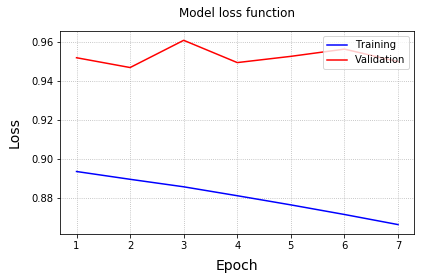

In [17]:
fig6 = plt.figure(6)
plt.plot(n_epochs, train_loss, '-b', label='Training')
plt.plot(n_epochs, val_loss, '-r', label='Validation')

plt.title('Model loss function', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_total_loss.pdf', format='pdf')
fig6.show()

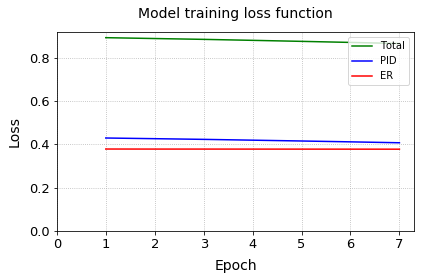

In [18]:
fig7 = plt.figure(7)
plt.plot(n_epochs, train_loss, '-g', label='Total')
plt.plot(n_epochs, train_pid_loss, '-b', label='PID')
plt.plot(n_epochs, train_en_loss, '-r', label='ER')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title('Model training loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=8, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_training_loss.pdf', format='pdf')
fig7.show()

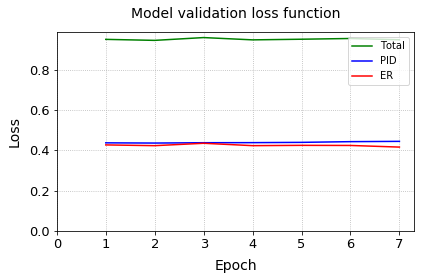

In [19]:
fig8 = plt.figure(8)
plt.plot(n_epochs, val_loss, '-g', label='Total')
plt.plot(n_epochs, val_pid_loss, '-b', label='PID')
plt.plot(n_epochs, val_en_loss, '-r', label='ER')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title('Model validation loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=8, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_validation_loss.pdf', format='pdf')
fig8.show()

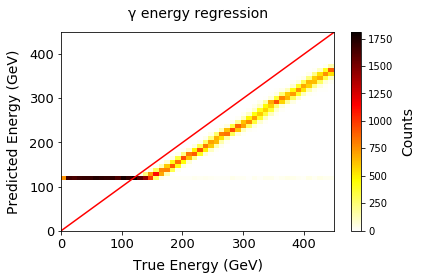

In [20]:
#gamma's energy hist
fig9 = plt.figure(9)
plt.hist2d(gamma_true_en, gamma_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('γ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_gammaEnHist.pdf', format='pdf')
fig9.show()

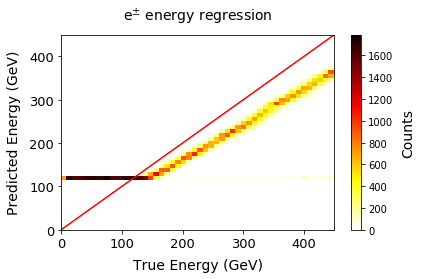

In [21]:
#electron's energy hist
fig10 = plt.figure(10)
plt.hist2d(electron_true_en, electron_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('e$^{±}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_electronEnHist.pdf', format='pdf')
fig10.show()

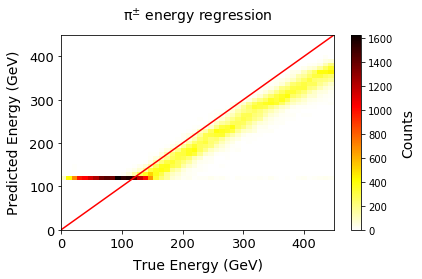

In [22]:
#pion's energy hist
fig11 = plt.figure(11)
plt.hist2d(pion_c_true_en, pion_c_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('π$^{±}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_pion_cEnHist.pdf', format='pdf')
fig11.show()

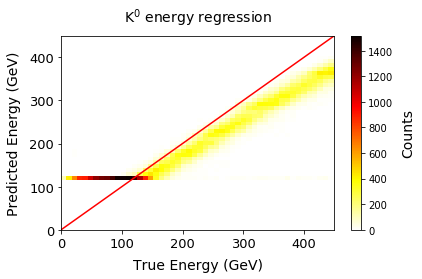

In [23]:
#kaon's energy hist
fig12 = plt.figure(12)
plt.hist2d(kaon_n_true_en, kaon_n_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('K$^{0}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_kaon_nEnHist.pdf', format='pdf')
fig11.show()

In [76]:
unique, counts = np.unique(pid_array, return_counts=True)
print(unique)
print(counts)

[0 1 2 3 4 5]
[ 85283  84965   2919  77135  75879 298254]
